<a href="https://colab.research.google.com/github/Lee-Song-Ha/CNN_project/blob/main/seyiCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 불러오기(드라이브 마운트)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of pictures: 21741

Number of different labels: 10

Labels: ['class1_image' 'test_image' 'class9_image' 'class3_image' 'class8_image'
 'class2_image' 'class4_image' 'class6_image' 'class7_image'
 'class5_image']


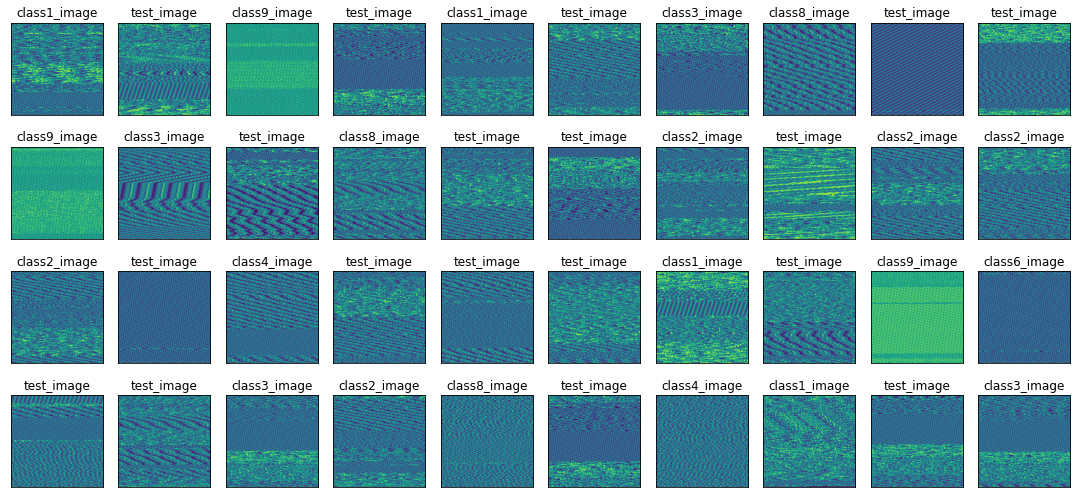

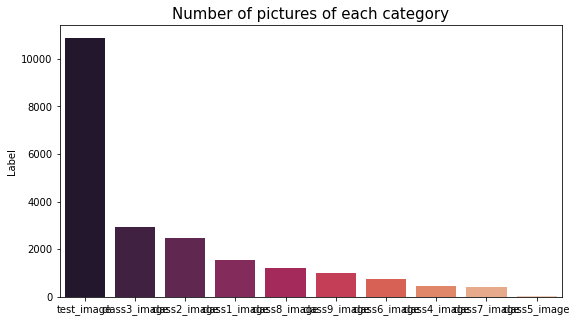

In [6]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

np.random.seed(3) #랜덤

# 이미지 경로를 데이터 프레임 형태로 만드는 함수
dir_ = Path('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata')
filepaths = list(dir_.glob(r'**/*.png')) # 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate, panda에 데이터프레임 합치는 함수.axis=1: 왼쪽+오른쪽으로 합치기
    df = pd.concat([filepath, labels], axis=1) 
                                              

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True) # dataframe에 랜덤하게 몇 %의 데이터를 뽑을 것인지.
                                                                   # frac=1:모든 데이터를 반환
    return df

df = proc_img(filepaths)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n') # Number of pictures: 13798
print(f'Number of different labels: {len(df.Label.unique())}\n') #Number of different labels: 8
print(f'Labels: {df.Label.unique()}') # unique()는 데이터에 고유값들이 어떠한 종류들이 있는지 알고 싶을 때 사용하는 함수
# Labels: ['person' 'airplane' 'car' 'dog' 'cat' 'flower' 'fruit' 'motorbike']

# 이미지 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), 
                        subplot_kw={'xticks': [], 'yticks': []}) # figsize:그래프 사이즈

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()
# fig란 figure로써 - 전체 subplot을 말한다. ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나. 전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen  = test_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata/test',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical')

Found 8698 images belonging to 9 classes.
Found 2170 images belonging to 9 classes.
Found 10873 images belonging to 1 classes.


In [8]:
# Initialising the CNN
# Sequential API는 tensorflow2에서 뉴럴 네트워크를 가장 쉽게 구성할 수 있는 방식
# add함수를 이용하면 layer가 순차대로 연결됨.
# add함수를 통해 각 layer들은 정확히 하나의 input값만 받을 수 있으며
# output 또한 하나의 tensor 형태로만 출력이 가능
cnn = tf.keras.models.Sequential() # 케라스는 Sequential을 사용하여 층을 차례대로 쌓음

# Step 1 - Convolution 합성곱 층, 32만큼 특성맵이 만들어짐. 입력층이라고 볼 수 있음.
# 커널 사이즈 크면 특징 감지하는데 효과가 떨어짐 3이나 5로 함
# 컬러 이미지는 RGB로 세 개의 채널로 구성 되어 있지만 그레이 스케일은 한 개의 채널이기에 3이 아닌 1입력
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 1]))

# Step 2 - Pooling
# 특성맵 크기 줄이는 작업(압축)
# stride 이동하는 크기. stride가 2면 2픽셀씩 이동. 2 by 2 크기가 만들어짐
# 풀링의 크기는 2
# 높이와 너비 절반 줄어듦
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
# 풀링으로 크기를 한 번 더 줄임(특정 데이터가 이미지 내의 위치 변화에 영향을 덜 받게 한다.)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
# Flatten() 입력 배열을 1차원으로 펼치는 역할. 연산 같은 거 없고 그냥 펼치는 역할. 
# 클래스 개수에 맞는 확률값을 얻기 위한 Dense 이전에 실행해야함.
# Dense 거치기 전에 먼저 flatten()으로 1차원으로 만들어야함
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
# 128개의 뉴런 거침.
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
# 9개의 출력 유닛을 가진 소프트맥스 층 추가, 최종적으로 9개 결과 출력
cnn.add(tf.keras.layers.Dense(units=9, activation='softmax')) 

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy', # 3개 이상의 클래스를 분류할 경우에 사용
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
#모델 성능확인(학습)
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10) #epochs:학습 횟수

In [17]:
# 모델 평가하기(테스트셋 돌려서 얻은 정확도)
print("-- Evaluate --")
scores = cnn.evaluate(test_gen, steps=5)
print("%s: %.2f%%" %(cnn.metrics_names[1], scores[1]*100))

-- Evaluate --
5/5 [==============================] - 3s 583ms/step - loss: 59.7745 - accuracy: 0.2250
accuracy: 22.50%


In [ ]:
!unzip -qq /content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata/image.zip -d /content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata

In [ ]:
import shutil
shutil.rmtree('경로')